El presente código está ordenado en orden cronológico en cuanto a su creación. Las métricas en las que se centró el informe y presentación son las últimas en el Script.

Importamos las librerías y los datos a utilizar

In [1]:
import pandas as pd
import numpy as np
import locale
from unidecode import unidecode
locale.setlocale(locale.LC_TIME, "es_ES.UTF-8")
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


abril = pd.read_excel("REGISTRO DE ASISTENCIA PUIG 10 ABRIL.xlsx")
julio = pd.read_excel("REGISTRO DE ASISTENCIA CB  07 JULIO.xlsx")
agosto = pd.read_excel("REGISTRO DE ASISTENCIA CB PUIG 07 AGOSTO.xlsx")
mensuales = pd.read_csv("Ventas mensuales E23-E25.csv", sep = ";", encoding="latin1")

Pre-procesamiento dataframe asistencias

In [2]:
asistencia_cv_abril = pd.DataFrame(abril).dropna()
asistencia_cv_julio = pd.DataFrame(julio).dropna()
asistencia_cv_agosto = pd.DataFrame(agosto).dropna()

asistencia_cv_julio = asistencia_cv_julio.rename(columns={"Unnamed: 0": "Número Local"})


asistencia_cv_abril['Mes'] = 'Abril'
asistencia_cv_julio['Mes'] = 'Julio'
asistencia_cv_agosto['Mes'] = 'Agosto'


asistencias_cv = pd.concat([asistencia_cv_abril, asistencia_cv_julio, asistencia_cv_agosto])

asistencias_cv['Nombre y Apellido'] = asistencias_cv['Nombre y Apellido'].str.strip().str.upper().apply(unidecode) #quitamos espacios, ponemos mayúsculas y quitamos carácteres especiales
asistencias_cv['Número Local'] = asistencias_cv['Número Local'].astype(str) #transformamos a string ya que es un código


mapping = { #para que todas las regiones tengan el mismo formato
    "I - Tarapacá": "01 - Tarapacá",
    "II - Antofagasta": "02 - Antofagasta",
    "III - Atacama": "03 - Atacama",
    "IV - Coquimbo": "04 - Coquimbo",
    "V - Valparaíso": "05 - Valparaíso",
    "VI - Libertador Bernardo O'Higgins": "06 - Libertador General Bernardo OHiggins",
    "VII - Maule": "07 - Maule",
    "VIII - Bio Bio": "08 - Biobío",
    "IX - Araucanía": "09 - La Araucanía",
    "X - Los Lagos": "10 - Los Lagos",
    "XI - Aysén": "11 - Aysén del General Carlos Ibañez del Campo",
    "XII - Magallanes": "12 - Magallanes y de la Antártica Chilena",
    "RM - Metropolitana": "13 - Metropolitana de Santiago",
    "XIV - Los Ríos": "14 - Los Ríos",
    "XV - Arica y Parinacota": "15 - Arica y Parinacota",
    "XVI - Ñuble": "16 - Ñuble"
}

asistencias_cv["Región"] = asistencias_cv["Región"].map(mapping)

asistencias_cv.loc[asistencias_cv["Número Local"].isin(["1020", "162", "164", "165", "350", "9044", "9069", "9093", "978"]), "Región"] = "16 - Ñuble" #corrección de datos


asistencias_cv

,Número Local,Región,Nombre y Apellido,Cargo,Mes
0,3,05 - Valparaíso,SANDRA VICENCIO,Consultora de Belleza Trainee,Abril
1,9,05 - Valparaíso,INGRID DIAZ,Consultora de Belleza Trainee,Abril
2,15,05 - Valparaíso,ANAIS ASTUDILLO,Consultora de Belleza Trainee,Abril
3,15,05 - Valparaíso,HELIA GONZALEZ,Consultora de Belleza Trainee,Abril
4,18,05 - Valparaíso,BARBARA CORDOVA,Consultora de Belleza Trainee,Abril
...,...,...,...,...,...
142,1096,13 - Metropolitana de Santiago,AURORA CANCINO,Consultora de Belleza Trainee,Agosto
143,1099,14 - Los Ríos,BELEN AMPUERO,Consultora de Belleza Trainee,Agosto
144,1106,07 - Maule,CECILIA PENA,Consultora de Belleza Trainee,Agosto
145,1124,13 - Metropolitana de Santiago,ROMINA GHIRARDELLI,Consultora de belleza Reemplazo,Agosto


Pre-procesamiento dataframe ventas

In [3]:
ventas_mensuales = pd.DataFrame(mensuales).dropna()

mensualesCV = ventas_mensuales.loc[
    (ventas_mensuales['Cadena'] == 'Cruz Verde') & 
    (ventas_mensuales['Online/Offline'] == 'Offline')
] 
#solo Cruz Verde y Offline

mensualesCV = mensualesCV.drop(["Cadena","Código SAP POS", "Online/Offline","Canal"], axis=1) #quitamos columnas redundantes
mensualesCV = mensualesCV.rename(columns={
    "Valores PVP c/IVA": "Ventas",
    "Local PUIG": "Número Local"
}) #cambiamos nombre de columnas para que coincidan con asistencia_cv

mensualesCV['Número Local'] = mensualesCV['Número Local'].astype(str) #transformamos a string ya que es un código

#sacamos los "." de miles, y cambiamos "," por "." para que sea un float
mensualesCV["Ventas"] = mensualesCV["Ventas"].str.replace(".", "", regex=False).str.replace(",", ".", regex=False).astype(float)
mensualesCV["Ventas"] = pd.to_numeric(mensualesCV["Ventas"]) #para asegurarnos de que queda numerico

mensualesCV['Fechas'] = mensualesCV['Fechas'].str.strip() #quitamos espacios
mensualesCV["Fechas"] = pd.to_datetime(mensualesCV["Fechas"], format="%B %Y", dayfirst=True)  #convertimos a datetime
mensualesCV = mensualesCV[ mensualesCV["Fechas"].dt.year < 2025 ]

meses_dict = {
    1: "Enero",      2: "Febrero",   3: "Marzo",     4: "Abril",
    5: "Mayo",       6: "Junio",     7: "Julio",     8: "Agosto",
    9: "Septiembre", 10: "Octubre",  11: "Noviembre", 12: "Diciembre"
}


# Extraemos el número de mes con .dt.month y mapeamos al nombre
mensualesCV["Mes"] = mensualesCV["Fechas"].dt.month.map(meses_dict)

mensualesCV = mensualesCV[(mensualesCV["Región"] != "No Definido") & (mensualesCV["Comuna"] != "No Definido")] #quitamos los locales que no tienen región o comuna definida

mensualesCV = mensualesCV.sort_values(by=["Fechas", "Región", "Comuna"], ascending=[True, True, True]) #ordenamos



mensualesCV

,Fechas,Región,Comuna,Número Local,Local,Ventas,Mes
812,2023-01-01,01 - Tarapacá,Alto Hospicio,508,"0508 Cruz Verde - Av. Chijo 3161, Alto Hospicio",433325.41,Enero
276,2023-01-01,01 - Tarapacá,Iquique,217,"0217 Cruz Verde - Vivar 706-710, Iquique",267227.59,Enero
277,2023-01-01,01 - Tarapacá,Iquique,211,0211 Cruz Verde - Av. Héroes de la Concepción ...,261636.97,Enero
278,2023-01-01,01 - Tarapacá,Iquique,1016,"1016 Cruz Verde - Teresa Wilms Mont 2263, Iquique",319135.39,Enero
589,2023-01-01,01 - Tarapacá,Iquique,210,0210 Cruz Verde - Av. Héroes de la Concepción ...,204978.69,Enero
...,...,...,...,...,...,...,...
40998,2024-12-01,16 - Ñuble,Chillán,1020,"1020 Cruz Verde - Arauco 623, Chillán",243506.13,Diciembre
41152,2024-12-01,16 - Ñuble,Chillán,9044,"9044 Cruz Verde - Maipón 701, Chillán",402669.82,Diciembre
41189,2024-12-01,16 - Ñuble,Chillán,9069,"9069 Cruz Verde - Libertad 1190, Chillán",565208.35,Diciembre
41317,2024-12-01,16 - Ñuble,Chillán,9093,"9093 Cruz Verde - Av. Vicente Méndez 1545, Chi...",966642.95,Diciembre


Creación dataframe con asistencias y ventas

In [4]:
# agrupamos por (Local, Mes) y contamos el número de filas (size)

df_asistencias_por_local_mes = (
    asistencias_cv
    .groupby(["Número Local", "Mes"])
    .size()  # Cuenta las filas por grupo
    .reset_index(name="TotalAsistencias")  # Convierte a DataFrame y nombra la columna
)

In [5]:
#unimos los dataframes de ventas y asistencias

df_merged = pd.merge(
    mensualesCV,
    df_asistencias_por_local_mes,
    on=["Número Local", "Mes"],
    how="left"
)

df_merged["TotalAsistencias"] = df_merged["TotalAsistencias"].fillna(0) #reemplazamos los NaN por 0, que son los locales sin asistencias


# Comparar las ventas entre años (2024-2023)

#Estraemos el año y mes en numeros
df_merged["Año"] = df_merged["Fechas"].dt.year
df_merged["Mesdt"] = df_merged["Fechas"].dt.month

# Ordenar datos antes de aplicar shift
df_merged.sort_values(by=["Número Local", "Mesdt", "Año"], inplace=True)
#Toma la fila anterior
df_merged["Ventas Año Anterior"] = df_merged.groupby(["Número Local", "Mesdt"])["Ventas"].shift(1)

# Para los años donde no hubo ventas en el mes correspondiente, se reemplaza por 0
df_merged["Ventas Año Anterior"].fillna(0, inplace=True)

# Calculamos el cambio
df_merged["Cambio $"] = df_merged["Ventas"] - df_merged["Ventas Año Anterior"]

# Dejamos solo las filas del 2024
df_merged= df_merged[df_merged['Fechas'].dt.year == 2024]

# Quitamos outliers
df_merged = df_merged[df_merged["Ventas Año Anterior"] != 0]
df_merged = df_merged[df_merged["Ventas"] != 0]
df_merged = df_merged[(df_merged["Cambio $"] >= -2.5e6) & (df_merged["Cambio $"] <= 3e6)]



/var/folders/wh/t_nmx4k979ldlz5ztt03rn7r0000gn/T/ipykernel_99502/3754282615.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Ventas Año Anterior"].fillna(0, inplace=True)


# Análisis

### Depreciación

In [6]:
def peso_lineal(meses):
    """
    peso lineal según los meses transcurridos
    0 meses -> 100%
    >12 meses -> 10%
    """
    if meses <= 0:
        return 1.0
    elif meses >= 12:
        return 0.1  
    else:
        # Interpolación lineal
        return 1.0 - (1.0 - 0.1)*(meses/12)  # determina el valor de las entradas de 0 a 12 (meses pasados)

In [7]:
#hacemos un merge con la misma matriz, teniendo el cruce de cada mesdt con cada mesdt_ant (1-1, 1-2, ... 1-12, 2-1, 2-2,...)
df_merged_2 = df_merged.merge(
    df_merged, 
    on=["Número Local"],       # unen por local
    suffixes=("", "_ant"),     # sufijos para evitar colisiones
)

#solo dejar las filas donde el mesdt_ant es menor al mesdt
df_merged_2 = df_merged_2[(df_merged_2["Mesdt_ant"] <= df_merged_2["Mesdt"])]

#calculamos en cada fila el valor de las capacitaciones multiplicadas por su peso (entonces, vemos el valor de cada totalasistencia_ant en el mesdt)
df_merged_2["DeltaMeses"] = df_merged_2["Mesdt"] - df_merged_2["Mesdt_ant"]
df_merged_2["Peso"] = df_merged_2["DeltaMeses"].apply(peso_lineal)
df_merged_2["AsistenciasPonderadas"] = (
    df_merged_2["TotalAsistencias_ant"] * df_merged_2["Peso"]
)

#agrupamos todos los calculos de asistencias por mes, es decir, cuantas asistencias ponderadas acumuladas hay por mes
acumulado = (
    df_merged_2
    .groupby(["Número Local", "Fechas", "Mesdt"], as_index=False)
    ["AsistenciasPonderadas"].sum()
    .rename(columns={"AsistenciasPonderadas": "CapacitacionesDepreciadas"})
)


#unimos el dataframe de ventas y asistencias con el acumulado de capacitaciones
df_merged_final = df_merged.merge(
    acumulado,
    on=["Número Local", "Fechas", "Mesdt"],
    how="left"
)


### Correlación general / total (todos los datos)

In [8]:
corr = df_merged_final["Cambio $"].corr(df_merged_final["CapacitacionesDepreciadas"])
print("Correlación entre Ventas y CapacitacionesDepreciadas:", corr)

#Muy baja correlación, por lo que no se puede concluir que haya una relación entre capacitaciones y ventas.
#Analizaremos la relación entre capacitaciones y ventas por región, para ver si hay alguna región que tenga una correlación más alta.

Correlación entre Ventas y CapacitacionesDepreciadas: 0.1903360494909209


### Correlación por región

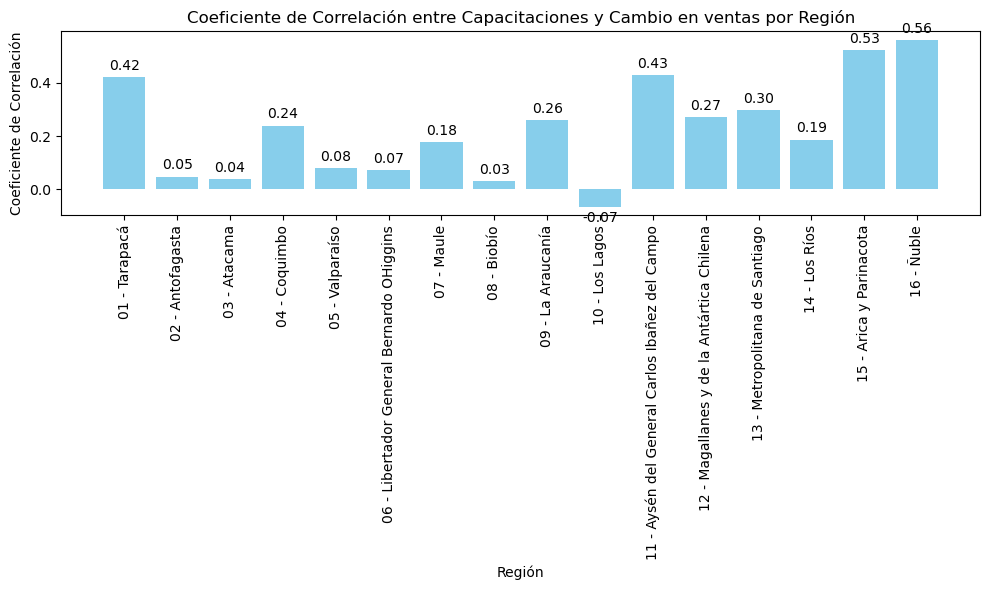

In [9]:
correlaciones = []
regiones = []

for region, grupo in df_merged_final.groupby("Región"):
    corr_value = grupo["CapacitacionesDepreciadas"].corr(grupo["Cambio $"])
    regiones.append(region)
    correlaciones.append(corr_value)
    
# Creamos un DataFrame con los resultados
df_corr = pd.DataFrame({"Región": regiones, "Coef_Corr": correlaciones})

# Graficamos un bar plot
plt.figure(figsize=(10,6))
bars = plt.bar(df_corr["Región"], df_corr["Coef_Corr"], color='skyblue')
plt.xlabel("Región")
plt.ylabel("Coeficiente de Correlación")
plt.title("Coeficiente de Correlación entre Capacitaciones y Cambio en ventas por Región")
plt.xticks(rotation=90)
plt.bar_label(bars, fmt="%.2f", padding=3)
plt.tight_layout()
plt.show()

In [10]:
# Determinamos nuestras regiones objetivo, el top 5 con mejor correlación

regiones_objetivo_sinM = [
    "01 - Tarapacá",
    #"02 - Antofagasta",
    #"03 - Atacama",
    #"04 - Coquimbo",
    #"05 - Valparaíso",
    #"06 - Libertador General Bernardo OHiggins",
    #"07 - Maule",
    #"08 - Biobío",
    #"09 - La Araucanía",
    #"10 - Los Lagos",
    "11 - Aysén del General Carlos Ibañez del Campo",
    #"12 - Magallanes y de la Antártica Chilena",
    #"13 - Metropolitana de Santiago",
    #"14 - Los Ríos",
    "15 - Arica y Parinacota",
    "16 - Ñuble"
]

regiones_objetivo = [
    "01 - Tarapacá",
    #"02 - Antofagasta",
    #"03 - Atacama",
    #"04 - Coquimbo",
    #"05 - Valparaíso",
    #"06 - Libertador General Bernardo OHiggins",
    #"07 - Maule",
    #"08 - Biobío",
    #"09 - La Araucanía",
    #"10 - Los Lagos",
    "11 - Aysén del General Carlos Ibañez del Campo",
    #"12 - Magallanes y de la Antártica Chilena",
    "13 - Metropolitana de Santiago",
    #"14 - Los Ríos",
    "15 - Arica y Parinacota",
    "16 - Ñuble"
]

In [11]:
cantidad_filas_rm = df_merged_final[df_merged_final['Región'] == '13 - Metropolitana de Santiago'].shape[0]
print(f"Cantidad de filas con Región '13 - Metropolitana de Santiago': {cantidad_filas_rm}")


Cantidad de filas con Región '13 - Metropolitana de Santiago': 3451


In [12]:
df_otras = df_merged_final[df_merged_final['Región'].isin(regiones_objetivo_sinM)]

# Calcular la cantidad de locales por región
tamaño_promedio = df_otras.groupby('Región').size().mean()
tamaño_promedio = int(round(tamaño_promedio))  # redondear al entero más cercano
print(f"Tamaño promedio de muestra a usar: {tamaño_promedio}")

df_rm = df_merged_final[df_merged_final['Región'] == '13 - Metropolitana de Santiago']

# Tomar muestra aleatoria del tamaño calculado
df_rm_muestra = df_rm.sample(n=tamaño_promedio, random_state=42) 
df_merged_final = pd.concat([df_otras, df_rm_muestra], ignore_index=True)
df_merged_final['Región'].value_counts()

Tamaño promedio de muestra a usar: 109


Región
01 - Tarapacá                                     183
13 - Metropolitana de Santiago                    109
16 - Ñuble                                        100
15 - Arica y Parinacota                            94
11 - Aysén del General Carlos Ibañez del Campo     60
Name: count, dtype: int64

In [13]:
df_merged_final["Cambio_%"] = (
    (df_merged_final["Ventas"] - df_merged_final["Ventas Año Anterior"]) / df_merged_final["Ventas Año Anterior"]
) * 100
# Eliminar infinitos y valores extremos poco confiables 
df_merged_final = df_merged_final.replace([np.inf, -np.inf], np.nan)
df_merged_final = df_merged_final.dropna(subset=["Cambio_%"])
q_low = df_merged_final["Cambio_%"].quantile(0.01)
q_high = df_merged_final["Cambio_%"].quantile(0.99)

df_merged_final = df_merged_final[(df_merged_final["Cambio_%"] >= q_low) & (df_merged_final["Cambio_%"] <= q_high)]

### Regresión no lineal con el Modelo Michaelis-Menten

Región: 01 - Tarapacá, a=2024213.42, b=13.34


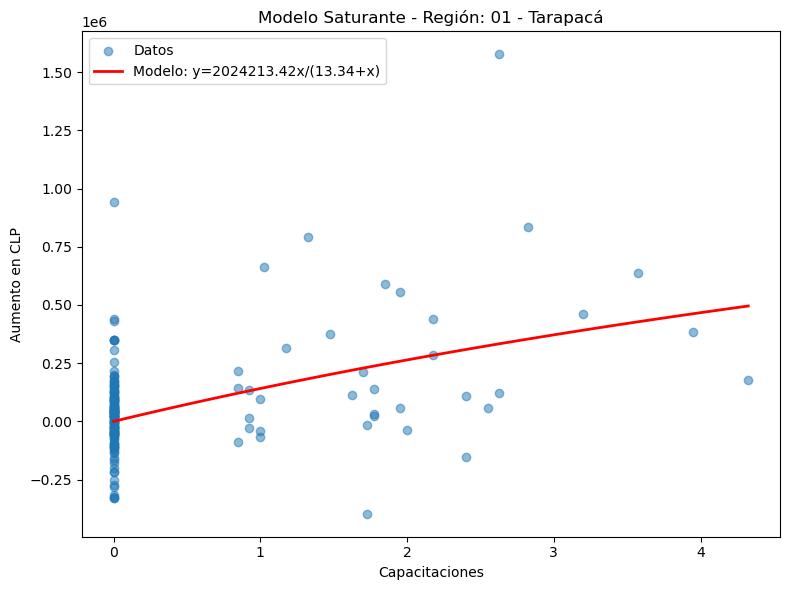

Región: 11 - Aysén del General Carlos Ibañez del Campo, a=920981.14, b=0.66


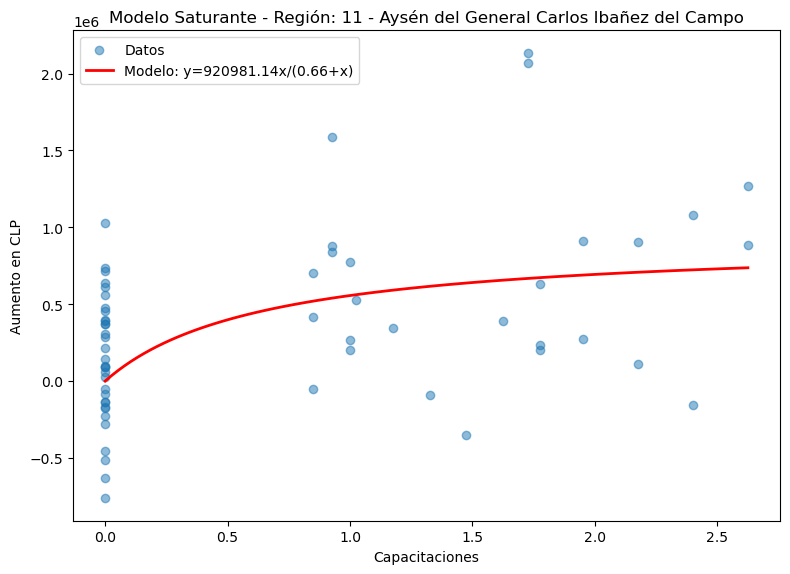

Región: 13 - Metropolitana de Santiago, a=351447.72, b=0.00


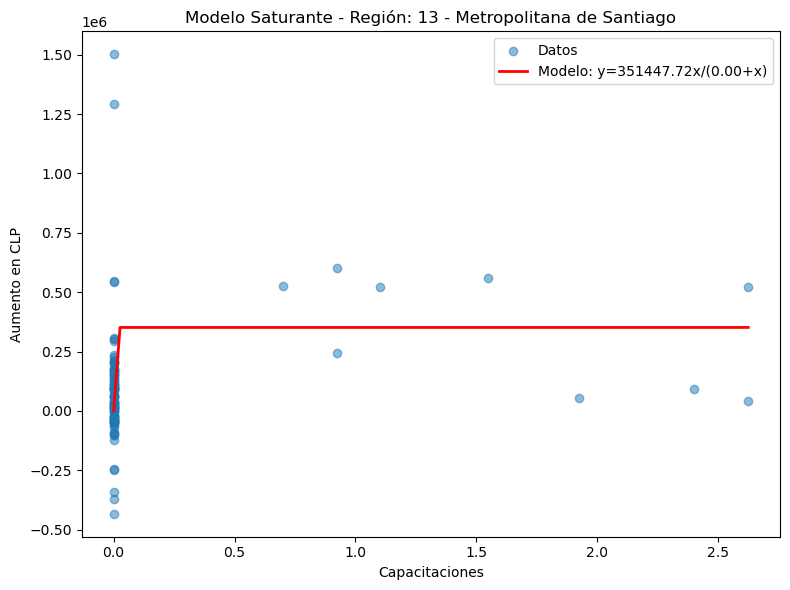

Región: 15 - Arica y Parinacota, a=1192416935802.75, b=11803139.82


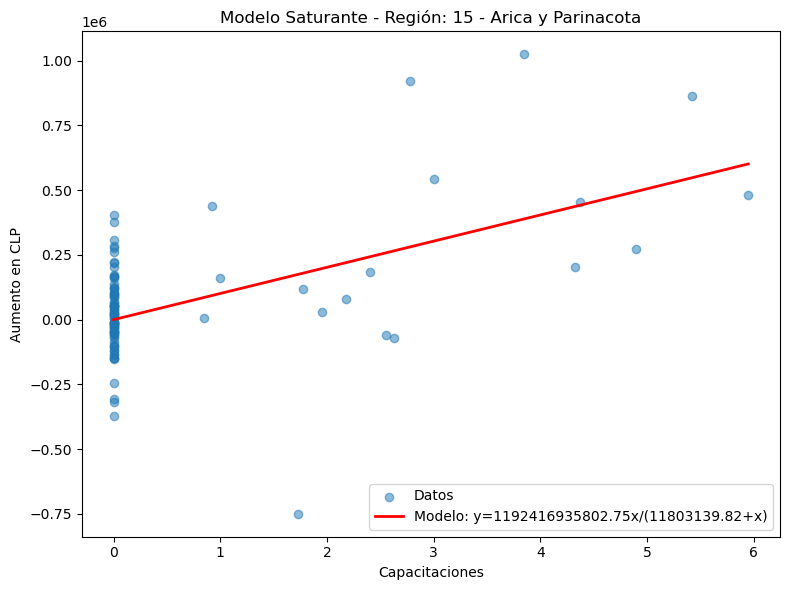

Región: 16 - Ñuble, a=280063856824.00, b=1078002.53


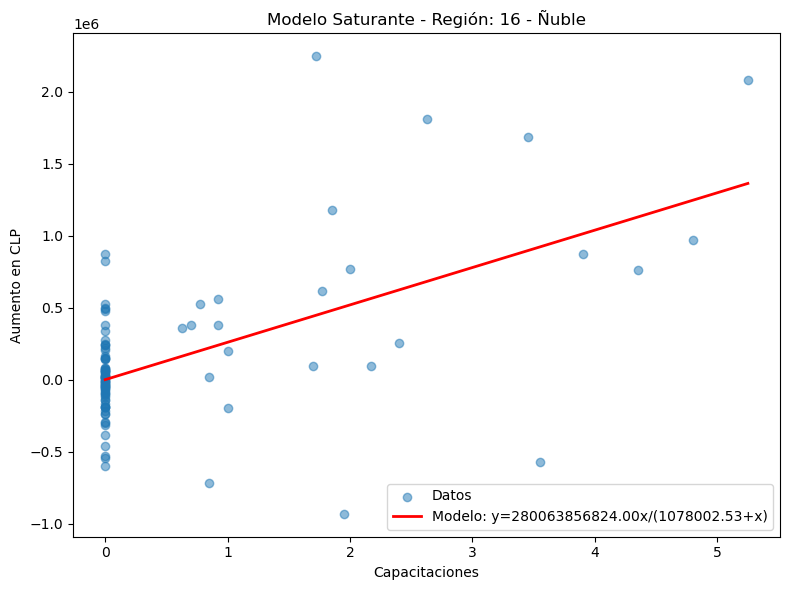

In [14]:
df_merged_final = df_merged_final.rename(columns={"Cambio $": "CambioPesos"})
parametros_por_region = {}
r2_por_region = {}

def saturating_model(x, a, b):
    # Modelo saturante (Michaelis-Menten)
    return (a * x) / (b + x)

for region, grupo in df_merged_final.groupby("Región"):
    if region not in regiones_objetivo:
        continue # Solo procesar las regiones objetivo
    x_data = grupo["CapacitacionesDepreciadas"].values
    y_data = grupo["CambioPesos"].values
    

    # Valor inicial para a (p0), le asignamos el mayor aumento en ventas
    p0 = [max(y_data), 1]
    lower_bounds = [0, 0]        # a >= 0, b >= 0
    upper_bounds = [np.inf, np.inf]  # sin límite superior
    
    try:
        params, cov = curve_fit(
            saturating_model,
            x_data,
            y_data,
            p0=p0,
            bounds=(lower_bounds, upper_bounds),
            maxfev=10000 #cantidad de evaluaciones
        )
        a_est, b_est = params

#        # Guardamos los datos por region
        parametros_por_region[region] = (a_est, b_est)

        y_pred = saturating_model(x_data, a_est, b_est)

        ss_res = np.sum((y_data - y_pred)**2)
        ss_tot = np.sum((y_data - y_data.mean())**2)
        r2 = 1 - ss_res / ss_tot

        r2_por_region[region] = r2


        print(f"Región: {region}, a={a_est:.2f}, b={b_est:.2f}")
        
        # Graficar el ajuste
        x_fit = np.linspace(min(x_data), max(x_data), 100)
        y_fit = saturating_model(x_fit, a_est, b_est)
        
        plt.figure(figsize=(8,6))
        plt.scatter(x_data, y_data, alpha=0.5, label="Datos")
        plt.plot(x_fit, y_fit, color='red', linewidth=2,
                 label=f"Modelo: y={a_est:.2f}x/({b_est:.2f}+x)")
        plt.xlabel("Capacitaciones")
        plt.ylabel("Aumento en CLP")
        plt.title(f"Modelo Saturante - Región: {region}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error al ajustar el modelo en la región {region}: {e}")

In [15]:
# Crear DataFrame con R² y cantidad de datos por región
df_r2 = pd.DataFrame.from_dict(r2_por_region, orient='index', columns=["R2"])
df_r2["n"] = df_r2.index.map(df_merged_final["Región"].value_counts())

# Limpiar regiones sin datos o con R2 faltante
df_r2 = df_r2.dropna().query("n > 0")

# Calcular R² ponderado
if not df_r2.empty:
    r2_ponderado = (df_r2["R2"] * df_r2["n"]).sum() / df_r2["n"].sum()
    print(f"\n📊 R² ponderado nacional = {r2_ponderado:.3f}")
else:
    print("⚠️ No hay datos válidos para calcular el R² ponderado.")


📊 R² ponderado nacional = 0.183


## Comparación al aumentar una capacitación en la cantidad de capacitaciones de Diciembre


In [16]:
#Vemos con cuantos locales tendríamos que trabajar

# 1. Mes de interés
mes_mas_actual = "Diciembre"
df_filtrado = df_merged_final[df_merged_final["Región"].isin(regiones_objetivo)]
locales_unicos_concap = df_filtrado[df_filtrado["CapacitacionesDepreciadas"] >= 1]["Número Local"].unique()

len(locales_unicos_concap)
# 2. Filtramos el DataFrame a ese mes
df_last_month = df_filtrado[df_filtrado["Mes"] == mes_mas_actual].copy()

print("Locales con al menos 1 capacitacion en el año")
locales_filtrados = df_last_month[df_last_month["Número Local"].isin(locales_unicos_concap)]
display(locales_filtrados.groupby("Región")["Número Local"].nunique())
print("-----------------------")
print("Locales parte de las regiones de interés")
df_last_month.groupby("Región")["Número Local"].nunique() #Locales por región con correlación

Locales con al menos 1 capacitacion en el año


Región
01 - Tarapacá                                     4
11 - Aysén del General Carlos Ibañez del Campo    3
13 - Metropolitana de Santiago                    1
15 - Arica y Parinacota                           2
16 - Ñuble                                        3
Name: Número Local, dtype: int64

-----------------------
Locales parte de las regiones de interés


Región
01 - Tarapacá                                     16
11 - Aysén del General Carlos Ibañez del Campo     5
13 - Metropolitana de Santiago                    10
15 - Arica y Parinacota                            8
16 - Ñuble                                         9
Name: Número Local, dtype: int64

### Locales que fueron capacitados al menos una vez en el año y son parte de las regiones de interés

In [17]:

# Máscara de locales a los que se les aplicará X+1, solo contamos los que tuvieron capacitación
mask_seleccionados = df_last_month["Número Local"].isin(locales_unicos_concap)


def saturating_model(x, a, b):
    return (a * x) / (b + x)

#ORIGINAL
def apply_saturating(row):
    """Escenario original (CapacitacionesDepreciadas sin modificar)."""
    region_actual = row["Región"]
    x_val = row["CapacitacionesDepreciadas"]
    a_reg, b_reg = parametros_por_region.get(region_actual, (0, 1)) #ojo, usamos parametros distintos según la región de la fila
    return saturating_model(x_val, a_reg, b_reg)

#+1 CAPACITACIÓN
def apply_saturating_plus1(row):
    """Escenario con +1 capacitación."""
    region_actual = row["Región"]
    x_val = row["CapacitacionesDepreciadas"] + 1
    a_reg, b_reg = parametros_por_region.get(region_actual, (0, 1))
    return saturating_model(x_val, a_reg, b_reg)

#ORIGINAL
df_last_month["pred_original"] = df_last_month.apply(apply_saturating, axis=1)

# Copiamos "pred_original" en pred_plus_1 
df_last_month["pred_plus_1"] = df_last_month["pred_original"].copy()


#Solo a los locales seleccionados, les aplicamos la función que suma +1

df_last_month.loc[mask_seleccionados, "pred_plus_1"] = (
    df_last_month.loc[mask_seleccionados].apply(apply_saturating_plus1, axis=1)
)


# Obtenemos la diferencia

df_last_month["diff"] = df_last_month["pred_plus_1"] - df_last_month["pred_original"]

# Efecto total y promedio solo para locales seleccionados
impacto_total_ultimo_mes = df_last_month.loc[mask_seleccionados, "diff"].sum()
impacto_promedio_ultimo_mes = df_last_month.loc[mask_seleccionados, "diff"].mean()

print("Mes donde se agregan capacitaciones:", mes_mas_actual)
print("Locales seleccionados:", sum(mask_seleccionados))
print("Impacto total al aumentar en +1 capacitación en locales seleccionados:", impacto_total_ultimo_mes)
print("Impacto promedio por local seleccionado:", impacto_promedio_ultimo_mes)


Mes donde se agregan capacitaciones: Diciembre
Locales seleccionados: 13
Impacto total al aumentar en +1 capacitación en locales seleccionados: 1708246.560811381
Impacto promedio por local seleccionado: 131403.58160087548


### Locales que no tuvieron capacitación en el año y son parte de las regiones de interés

In [18]:


mes_mas_actual = "Diciembre"

#Filtramos el DataFrame a ese mes y donde CapacitacionesDepreciadas sea 0
df_last_month = df_filtrado[
    (df_filtrado["Mes"] == mes_mas_actual) & 
    (df_filtrado["CapacitacionesDepreciadas"] == 0)
].copy()


def saturating_model(x, a, b):
    return (a * x) / (b + x)

#ORIGINAL
def apply_saturating(row):
    """Escenario original (CapacitacionesDepreciadas sin modificar)."""
    region_actual = row["Región"]
    x_val = row["CapacitacionesDepreciadas"]
    a_reg, b_reg = parametros_por_region.get(region_actual, (0, 1)) 
    return saturating_model(x_val, a_reg, b_reg)

#+1 CAPACITACIÓN
def apply_saturating_plus1(row):
    """Escenario con +1 (solo se usará en los locales seleccionados)."""
    region_actual = row["Región"]
    x_val = row["CapacitacionesDepreciadas"] + 1
    a_reg, b_reg = parametros_por_region.get(region_actual, (0, 1))
    return saturating_model(x_val, a_reg, b_reg)

#ORIGINAL
df_last_month["pred_original"] = df_last_month.apply(apply_saturating, axis=1)

# Copiamos "pred_original" en pred_plus_1 
df_last_month["pred_plus_1"] = df_last_month["pred_original"].copy()

#Solo a los locales seleccionados, les aplicamos la función que suma +1
df_last_month["pred_plus_1"] = df_last_month.apply(apply_saturating_plus1, axis=1)

# Obtenemos la diferencia
df_last_month["diff"] = df_last_month["pred_plus_1"] - df_last_month["pred_original"]

# Efecto total y promedio solo para locales seleccionados
impacto_total_ultimo_mes = df_last_month["diff"].sum()
impacto_promedio_ultimo_mes = df_last_month["diff"].mean()


# Efecto total y promedio solo para locales seleccionados
print("Mes donde se agregan capacitaciones:", mes_mas_actual)
print("Locales seleccionados:", len(df_last_month))
print("Impacto total al aumentar en +1 capacitación:", impacto_total_ultimo_mes)
print("Impacto promedio por local:", impacto_promedio_ultimo_mes)

Mes donde se agregan capacitaciones: Diciembre
Locales seleccionados: 35
Impacto total al aumentar en +1 capacitación: 8134594.314921299
Impacto promedio por local: 232416.9804263228


### Todos los locales parte de las regiones de interés

In [19]:

mes_mas_actual = "Diciembre"

df_last_month = df_filtrado[df_filtrado["Mes"] == mes_mas_actual].copy()



def saturating_model(x, a, b):
    return (a * x) / (b + x)


#ORIGINAL
def apply_saturating(row):
    """Escenario original (CapacitacionesDepreciadas sin modificar)."""
    region_actual = row["Región"]
    x_val = row["CapacitacionesDepreciadas"]
    a_reg, b_reg = parametros_por_region.get(region_actual, (0, 1)) 
    return saturating_model(x_val, a_reg, b_reg)


#+1 CAPACITACIÓN
def apply_saturating_plus1(row):
    """Escenario con +1 (solo se usará en los locales seleccionados)."""
    region_actual = row["Región"]
    x_val = row["CapacitacionesDepreciadas"] + 1
    a_reg, b_reg = parametros_por_region.get(region_actual, (0, 1))
    return saturating_model(x_val, a_reg, b_reg)


#ORIGINAL
df_last_month["pred_original"] = df_last_month.apply(apply_saturating, axis=1)

# Copiamos "pred_original" en pred_plus_1
df_last_month["pred_plus_1"] = df_last_month["pred_original"].copy()

#Solo a los locales seleccionados, les aplicamos la función que suma +1
df_last_month["pred_plus_1"] = df_last_month.apply(apply_saturating_plus1, axis=1)

# Obtenemos la diferencia
df_last_month["diff"] = df_last_month["pred_plus_1"] - df_last_month["pred_original"]

# Efecto total y promedio solo para locales seleccionados
impacto_total_ultimo_mes = df_last_month["diff"].sum()
impacto_promedio_ultimo_mes = df_last_month["diff"].mean()

print("Mes donde se agregan capacitaciones:", mes_mas_actual)
print("Locales seleccionados:", len(df_last_month))
print("Impacto total al aumentar en +1 capacitación en locales seleccionados:", impacto_total_ultimo_mes)
print("Impacto promedio por local seleccionado:", impacto_promedio_ultimo_mes)


#Porcentaje del sellout promedio total

locales_analizados = df_last_month["Número Local"].unique()
mask_locales = df_merged_final["Número Local"].isin(locales_analizados)
df_mismos_locales = df_merged_final[mask_locales]
ventas_mensuales = df_mismos_locales.groupby("Mes")["Ventas"].sum().reset_index()
promedio_mensual_total = ventas_mensuales["Ventas"].mean()
porcentaje_impacto = impacto_total_ultimo_mes / promedio_mensual_total * 100

# 6. Imprimir resultados
print(f"Promedio mensual total de ventas (todos los locales analizados): ${promedio_mensual_total:,.2f}")
print(f"Impacto total como % del promedio mensual de esos locales: {porcentaje_impacto:,.2f}%")


Mes donde se agregan capacitaciones: Diciembre
Locales seleccionados: 48
Impacto total al aumentar en +1 capacitación en locales seleccionados: 9842840.87573268
Impacto promedio por local seleccionado: 205059.18491109752
Promedio mensual total de ventas (todos los locales analizados): $38,310,130.73
Impacto total como % del promedio mensual de esos locales: 25.69%


# Análisis comparativo entre locales con y sin capacitación

In [20]:
df_filtrado_f = df_merged_final.copy()#[df_merged_final["Región"].isin(regiones_objetivo)]
# Crear dos grupos
con_cap = df_filtrado_f[df_filtrado_f["CapacitacionesDepreciadas"] > 0]
sin_cap = df_filtrado_f[df_filtrado_f["CapacitacionesDepreciadas"] == 0]

# Calcular y mostrar estadísticas descriptivas
resumen = pd.DataFrame({
    "Grupo": ["Con capacitación", "Sin capacitación"],
    "Promedio cambio %": [con_cap["Cambio_%"].mean(), sin_cap["Cambio_%"].mean()],
    "Mediana cambio %": [con_cap["Cambio_%"].median(), sin_cap["Cambio_%"].median()],
    "Desviación estándar": [con_cap["Cambio_%"].std(), sin_cap["Cambio_%"].std()],
    "Observaciones": [len(con_cap), len(sin_cap)]
})

print(resumen)

              Grupo  Promedio cambio %  Mediana cambio %  Desviación estándar  \
0  Con capacitación          49.754531         28.122603            81.373596   
1  Sin capacitación          48.151962         10.865224           142.901379   

   Observaciones  
0            114  
1            420  


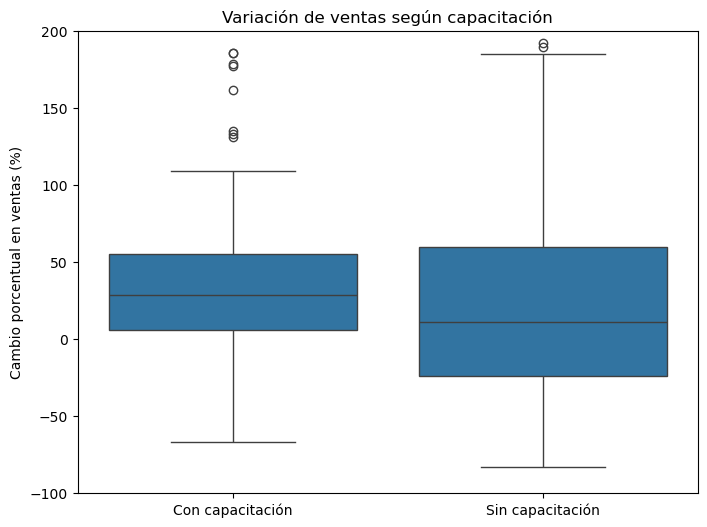

In [21]:
df_plot = pd.concat([
    con_cap.assign(Grupo='Con capacitación'),
    sin_cap.assign(Grupo='Sin capacitación')
])

plt.figure(figsize=(8, 6))
sns.boxplot(x='Grupo', y='Cambio_%', data=df_plot, showfliers=True)  # O showfliers=False si quieres ocultar outliers
plt.ylabel('Cambio porcentual en ventas (%)')
plt.xlabel('')
plt.title('Variación de ventas según capacitación')
plt.ylim(-100, 200)
plt.show()

In [22]:
# Crear los grupos según capacitación
con_cap = df_filtrado_f[df_filtrado_f["CapacitacionesDepreciadas"] > 0 ]
sin_cap = df_filtrado_f[df_filtrado_f["CapacitacionesDepreciadas"] == 0]

# Resumen del cambio en pesos
resumen_valor = pd.DataFrame({
    "Grupo": ["Con capacitación", "Sin capacitación"],
    "Promedio cambio $": [con_cap["CambioPesos"].mean(), sin_cap["CambioPesos"].mean()],
    "Mediana cambio $": [con_cap["CambioPesos"].median(), sin_cap["CambioPesos"].median()],
    "Desviación estándar $": [con_cap["CambioPesos"].std(), sin_cap["CambioPesos"].std()],
    "Observaciones": [len(con_cap), len(sin_cap)]
})

print(resumen_valor)

              Grupo  Promedio cambio $  Mediana cambio $  \
0  Con capacitación      414201.358421         280541.31   
1  Sin capacitación       44578.666500          25763.50   

   Desviación estándar $  Observaciones  
0          569977.284654            114  
1          229846.129564            420  


In [23]:
display(con_cap['Número Local'].nunique())
display(sin_cap['Número Local'].nunique())

20

121

In [24]:
total_con_cap = con_cap["CambioPesos"].sum()
total_sin_cap = sin_cap["CambioPesos"].sum()
diferencia_total = total_con_cap - total_sin_cap
print(f"Diferencia total acumulada: ${diferencia_total:,.0f}")


Diferencia total acumulada: $28,495,915


In [25]:
promedio_con = con_cap["CambioPesos"].mean()
promedio_sin = sin_cap["CambioPesos"].mean()

diferencia_promedio = promedio_con - promedio_sin
print(f"Diferencia promedio: ${diferencia_promedio:,.2f}")


Diferencia promedio: $369,622.69
